# **MelSpectrogram Construction**


## **1. Imports**

In [15]:
#DO NOT REMOVE
!pip install -qq git+https://github.com/google-research/perch-hoplite.git

from perch_hoplite import audio_io
import IPython
import librosa
from librosa import display as librosa_display
from IPython.display import display as ipy_display

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [22]:
import matplotlib.pyplot as plt
from IPython.display import Audio as audio_widget
import numpy as np
from scipy.signal.windows import hann

## **2. Loading Audio**

In [17]:
xeno_canto_id = 'XC1059613'

#lowering id case to avoid file path conflict
xeno_canto_id=xeno_canto_id.lower()

sample_rate_hz = 32_000
frame_rate = 100

audio=audio_io.load_xc_audio(xeno_canto_id,sample_rate=sample_rate_hz)

display(audio_widget(audio,rate=sample_rate_hz))

## **3.Functions**

In [24]:
#here am trying the steps before to see if it is possible to generate a similar
#spectrum as before.
#creating full spectrum
window_size=1024

def get_frequency_components(hanning_window,window_size,window):

          windowed = window * hanning_window
          #using the fast fourier transform instead of dfft for speed optimization
          fft = np.fft.rfft(windowed)


          power_spectrum = np.abs(fft)**2

          positive_freq = power_spectrum

          return positive_freq


In [25]:
def create_windows_hanned_frequencies(audio):
    length=len(audio)
    offset_s = 0

    window_size = 2048

    windows=[]
    specs=[]

    step = int(offset_s * 32_000)
    start=step

    hanning_window=hann(window_size)
    mel_mat = librosa.filters.mel(sr=sample_rate_hz, n_fft=window_size, n_mels=128)

    #making windows and computing the spectrums
    while(start>=0 and start<length):
            end=start+window_size
            if(end>=length):
                   start=-1
                   continue
            #applying hanning window
            sample_window=audio[start:end]*hanning_window
            freq=get_frequency_components(hanning_window,window_size,sample_window)

            #using the mel filter bank matrix
            new_spec=mel_mat@freq
            #storing the spectrums and windows
            specs.append(new_spec)
            windows.append(sample_window)

            start=end
    return windows,specs



In [26]:
def display_spectral(specs,sr):

        specs=np.array(specs)
        time_frames,freq_bins=specs.shape
        freqs=np.linspace(0,sr/2,freq_bins)

        times = np.arange(time_frames)
        #for the frequencies ,repeat each time instance/value

        # since the  windows are non-overlapping
        hop_length = window_size
        times_sec = times * hop_length / sr
        time = np.repeat(times_sec, freq_bins) #time axis in seconds

        #for each time, repeat each frequency instance/value
        freq_vals=np.tile(freqs,time_frames)

        #power for each point, times_frame x freq_bins size array
        power=specs.flatten()

        #convert the power to db
        power_db = 10 * np.log10(np.maximum(power, 1e-10))


        #plotting the spectrum as a scatter
        plt.scatter(time,freq_vals,c=power_db,cmap='magma')
        plt.title("Custom Mel Spectrum (Reconstructed)")
        librosa_display.plt.colorbar(format='%+0.0f dB')
        plt.ylabel('Hz')
        plt.xlabel('Time (s)')
        plt.show()



## **4. Melspectrogram Display**

generating windows,freqencies and spectrum data
plotting spectrum as scatter points


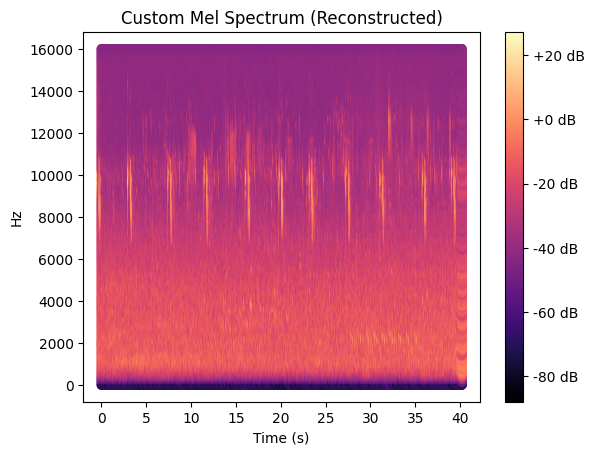

In [27]:
print("generating windows,freqencies and spectrum data")
windows,specs=create_windows_hanned_frequencies(audio)
print('plotting spectrum as scatter points')
display_spectral(specs,sr=sample_rate_hz)